# Tabular Playground #1: Bimodal Regression

* [Problem Definition](#Problem-Definition)<br>
* [Modality](#Modality)<br>
* [Data Overview](#Data-Overview)<br>
    * [Target](#Target)<br>
    * [cont# Features](#cont-Features)<br>
* [Model Baseline](#Model-Baseline)<br>
* [Feature Engineering Techniques](#Feature-Engineering-Techniques)<br>
    * [Gaussian Mixture Modelling](#Gaussian-Mixture-Modelling)<br>
    * [Binning](#Binning)<br>
    * [Statistical Features](#Statistical-Features)<br>
    * [Deep Feature Synthesis](#Deep-Feature-Synthesis)<br>
    * [Summary](#Summary)<br>
* [EDA](#EDA)<br>

# Problem Definition

In this challenge, we are asked to build a **regression** model. Without further context, we are given some features with **continuous values** to predict a continuous target. This way, we can practice on focussing on the data without requiring any specific domain knowledge because the column names `cont#` do not indicate any further information.

There is no missing data but instead we have a different obstacle that we have to overcome - **bimodal distribution of the target variable** and multimodal distributions of the features.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Configurations
N_SPLITS = 5
SEED = 42

train_df = pd.read_csv("../input/tabular-playground-series-jan-2021/train.csv")
display(train_df.head())
#print('Train data dimension: ', train_df.shape)

test_df = pd.read_csv("../input/tabular-playground-series-jan-2021/test.csv")
#print('Test data dimension: ', test_df.shape)
#display(test_df.head())

sample_submission = pd.read_csv("../input/tabular-playground-series-jan-2021/sample_submission.csv")
#print('Sample submission dimension: ', sample_submission.shape)
#display(sample_submission.head())


print(f"Missing data in the train data: {train_df.isna().sum(axis=0).any()}")
print(f"Missing data in the test data: {test_df.isna().sum(axis=0).any()}")

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


Missing data in the train data: False
Missing data in the test data: False


# Modality

In this challenge, we will learn about the modality of a distribution. You can find the modality of a distribution by counting the number of its peaks. There are unimodal, bimodal and multimodal distributions.
The most commonly known distribution is unimodal with only one peak. This is probably also the most comfortable distribution to work with. If you have two peaks, it is called bimodal, and if you have three or more peaks, then it is called multimodal.

Also, **don't get it confused with "multimodal learning"**, which describes problems with mixed feature modalities, such as pictures and text.

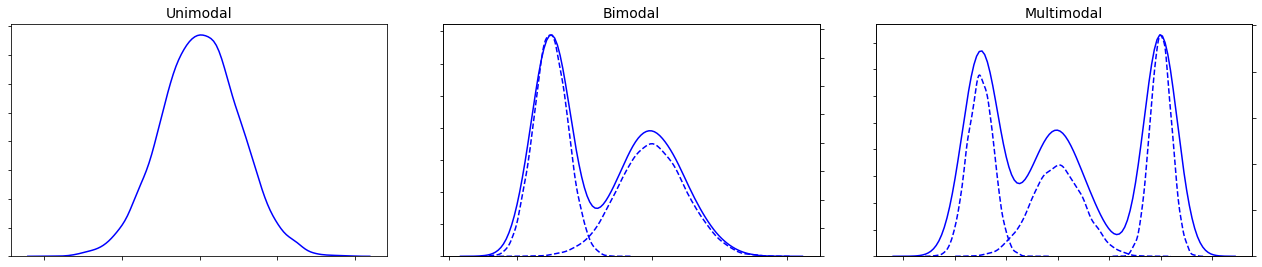

In [2]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# Unimodal
sns.distplot(np.random.normal(10, 5, 10000), ax=ax[0], hist=False, color='blue')
ax[0].set_title('Unimodal', fontsize=14)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

# Bimodal
sample_bimodal = pd.DataFrame({'feature1' : np.random.normal(10, 5, 10000),
                   'feature2' : np.random.normal(40, 10, 10000),
                   'feature3' : np.random.randint(0, 2, 10000),
                  })

sample_bimodal['combined'] = sample_bimodal.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else x.feature2, axis=1)

sns.distplot(sample_bimodal['combined'].values, ax=ax[1], color='blue', hist=False)

ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis

sns.distplot(sample_bimodal.feature1, ax=ax2, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_bimodal.feature2), ax=ax2, color='blue', kde_kws={'linestyle':'--'}, hist=False)

f.tight_layout()  # otherwise the right y-label is slightly clipped

ax[1].set_title('Bimodal', fontsize=14)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax2.set_yticklabels([])


# Multimodal
sample_multi = pd.DataFrame({'feature1' : np.random.normal(10, 5, 10000),
                   'feature2' : np.random.normal(40, 10, 10000),
                   'feature3' : np.random.randint(0, 3, 10000),
                               'feature4' : np.random.normal(80, 4, 10000),
                  })

sample_multi['combined'] = sample_multi.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else (x.feature2 if x.feature3 == 1 else x.feature4), axis=1 )

sns.distplot(sample_multi['combined'].values, ax=ax[2], color='blue', hist=False)

ax3 = ax[2].twinx()  # instantiate a second axes that shares the same x-axis

sns.distplot(sample_multi.feature1, ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_multi.feature2), ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_multi.feature4), ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)

f.tight_layout()  # otherwise the right y-label is slightly clipped

ax[2].set_title('Multimodal', fontsize=14)
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])
ax3.set_yticklabels([])

plt.show()

# Data Overview

## Target
* It looks like an overlay of two different distributions - when the data distribution has two peaks, it is called **bimodal distribution**.
* There is exactly one data point with a target value of 0 - this looks very much like an **outlier**. We should probably drop it since it is only one single data point.
* The data does not seem to be skewed and therefore does not necessarily need to be transformed (if non-tree-based models are used - for tree-based models this would not matter anyways).

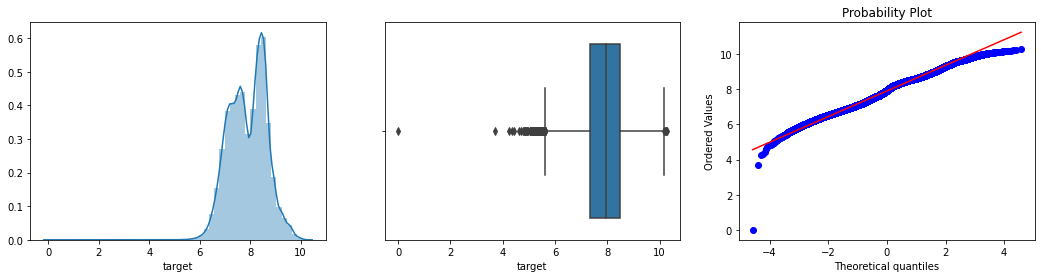

In [3]:
#display(train_df.target.describe())
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
sns.distplot(train_df.target, ax=ax[0])
sns.boxplot(train_df.target, ax=ax[1])
stats.probplot(train_df['target'], plot=ax[2])
plt.show()

In [4]:
# Drop one outlier
train_df = train_df[train_df.target != 0].reset_index(drop=True)

,feature1,feature2,feature3,target
0,13.386716,36.748996,0,13.386716
1,12.797205,26.140612,0,12.797205
2,11.587146,53.474592,0,11.587146
3,14.363688,55.075548,1,55.075548
4,5.087211,23.065085,0,5.087211


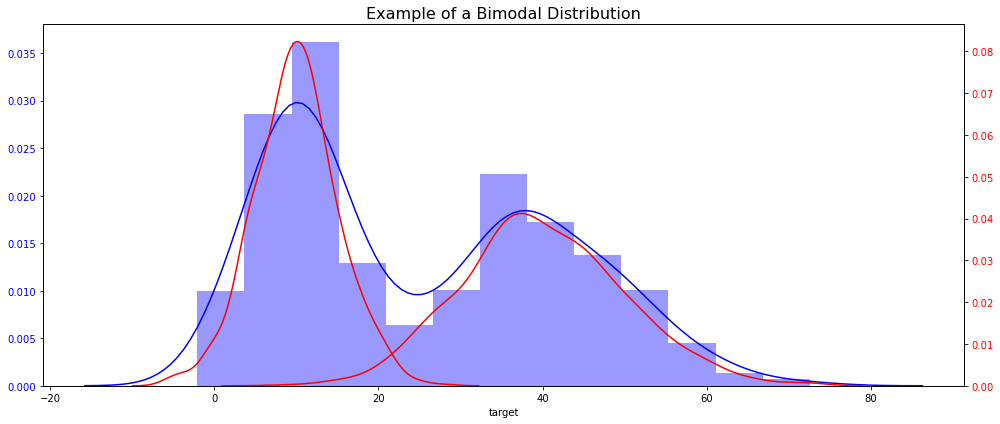

In [5]:
df = pd.DataFrame({'feature1' : np.random.normal(10, 5, 1000),
                   'feature2' : np.random.normal(40, 10, 1000),
                   'feature3' : np.random.randint(0, 2, 1000),
                  })

df['target'] = df.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else x.feature2, axis=1)

display(df.head())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
color = 'blue'
sns.distplot(df.target, ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
sns.distplot(df.feature1, ax=ax2, color=color, hist=False)
sns.distplot((df.feature2), ax=ax2, color=color, hist=False)

ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Example of a Bimodal Distribution', fontsize=16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## cont# Features
Let's look at the `cont#` features in bulk.
For below plots we can see some **odd distributions: all `cont#` features show multiple 'peaks' with no sign of a normal distribution.**

Um, ok... what is going on?! We definitely need to dig deeper here before we can start building our model.

We already saw that our `target` variable has a bimodal distribution. Now we have some feature distributions with multiple peaks. This is called **multimodal distribution**.


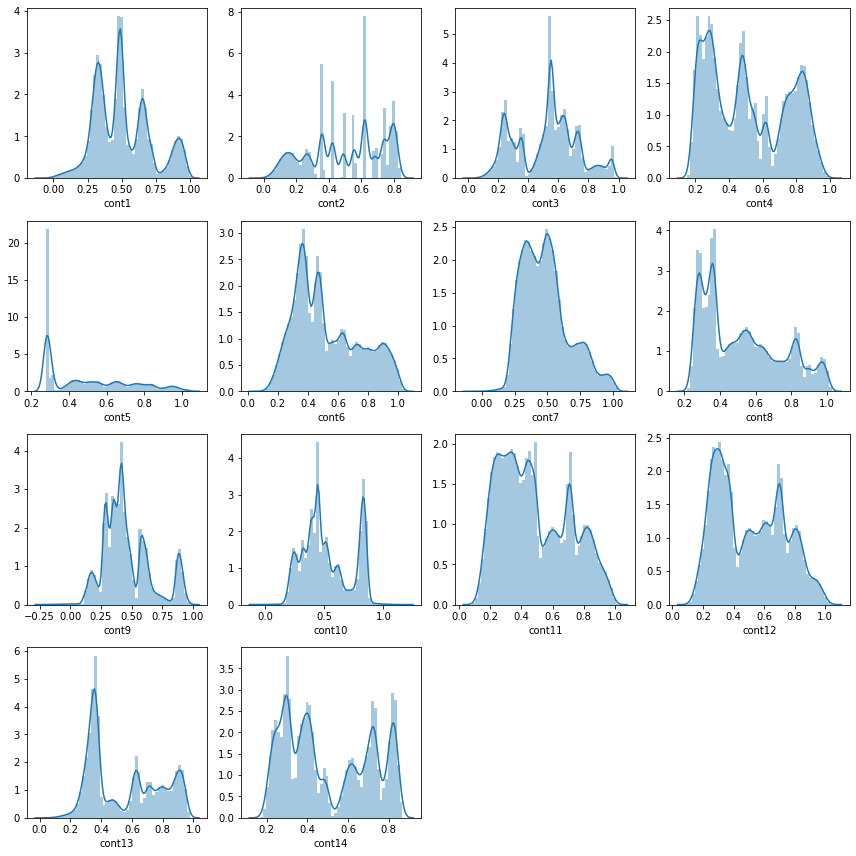

In [6]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)
sns.distplot(train_df['cont1'], ax=ax[0, 0])
sns.distplot(train_df['cont2'], ax=ax[0, 1])
sns.distplot(train_df['cont3'], ax=ax[0, 2])
sns.distplot(train_df['cont4'], ax=ax[0, 3])

sns.distplot(train_df['cont5'], ax=ax[1, 0])
sns.distplot(train_df['cont6'], ax=ax[1, 1])
sns.distplot(train_df['cont7'], ax=ax[1, 2])
sns.distplot(train_df['cont8'], ax=ax[1, 3])

sns.distplot(train_df['cont9'], ax=ax[2, 0])
sns.distplot(train_df['cont10'], ax=ax[2, 1])
sns.distplot(train_df['cont11'], ax=ax[2, 2])
sns.distplot(train_df['cont12'], ax=ax[2, 3])

sns.distplot(train_df['cont13'], ax=ax[3, 0])
sns.distplot(train_df['cont14'], ax=ax[3, 1])
f.delaxes(ax[3, 2])
f.delaxes(ax[3, 3])
plt.tight_layout()
plt.show()

#f, ax = plt.subplots(nrows=14, ncols=3, figsize=(12, 28))
#for i, var in enumerate(train_df.columns[train_df.columns.str.startswith('cont')]):
#    sns.distplot(train_df[var], ax=ax[i, 0])
#    sns.boxplot(train_df[var], ax=ax[i, 1])
#    stats.probplot(train_df[var], plot=ax[i, 2])
#plt.tight_layout()
#plt.show()

From a top level point of view, we can see that **none of the features seem to be correlated to the `target`** and `cont14`. 

Additionally, there seems to be a highly correlated cluster consisting of `cont1` and `cont6` through `cont13`.

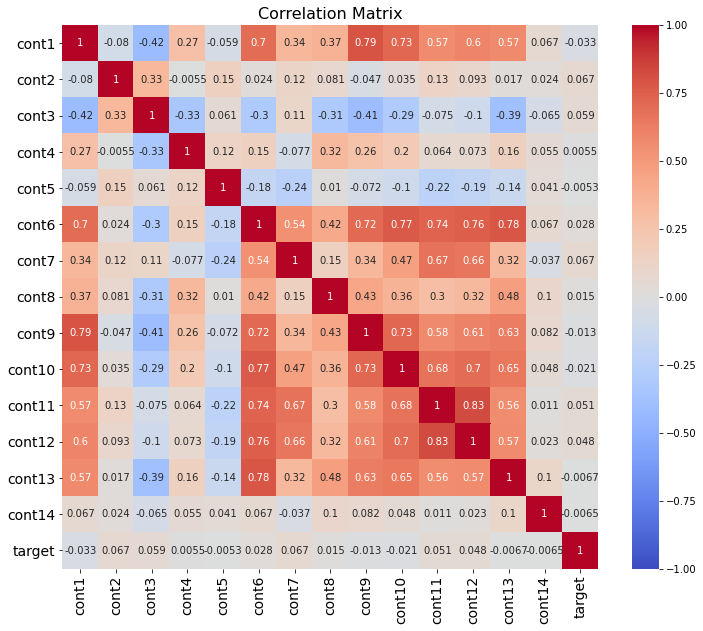

In [7]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(train_df[train_df.columns[train_df.columns != 'id']].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

# Model Baseline

Alothough, we did not do any feature engineering so far, let's create a simple LightGBM baseline to get a **benchmark** first. The baselibe in [Tawara](https://www.kaggle.com/ttahara)'s notebook [TPS Jan 2021: GBDTs Baseline](https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline) will be the base for our experiments.

In [8]:
# Baseline model parameters copied from
# https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline

model_params = {
    "objective": "root_mean_squared_error",
    "learning_rate": 0.1, 
    "seed": 42,
    'max_depth': 7,
    'colsample_bytree': .85,
    "subsample": .85,
}
    
train_params = {
    "early_stopping_rounds": 100,
    "verbose_eval": 50,
}

def visualize_results(y_pred, y_train, features, feature_importances):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    color = 'blue'
    ax[0].set_ylabel('Ground Truth', color=color, fontsize=14)
    sns.distplot(y_train, ax=ax[0], color=color)
    ax[0].tick_params(axis='y', labelcolor=color)

    ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
    sns.distplot(pd.Series(y_pred), ax=ax2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax[0].set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)

    pd.DataFrame({'features' : features, 
                  'feature_importance': feature_importances}
                ).set_index('features').sort_values(by='feature_importance', ascending=False).head(10).plot(kind='bar', ax=ax[1])
    ax[1].set_title('Top 10 Most Important Features', fontsize=16)

    for tick in ax[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        tick.label.set_rotation(0) 

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772


Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703782	valid_1's rmse: 0.705303
[100]	training's rmse: 0.696372	valid_1's rmse: 0.701467
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696372	valid_1's rmse: 0.701467
RMSE: 0.70147

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.704066	valid_1's rmse: 0.704717
[100]	training's rmse: 0.696435	valid_1's rmse: 0.700759
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696435	valid_1's rmse: 0.700759
RMSE: 0.70076

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703368	valid_1's rmse: 0.708573
[100]	training's rmse: 0.695655	valid_1's rmse: 0.704101
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.695655	valid_1's rmse: 0.704101
RMSE: 0.70410

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse:

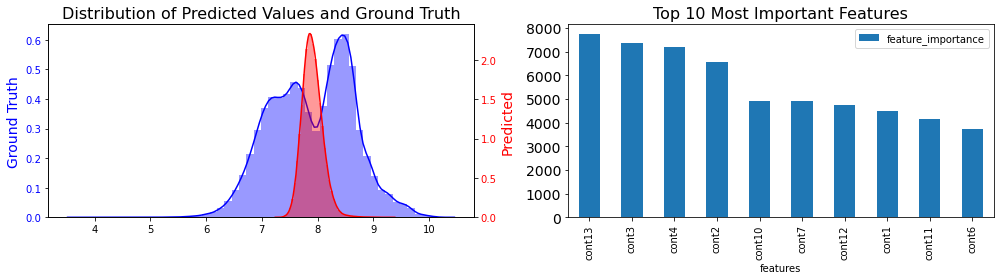

In [9]:
def run_model(X, y, X_test):
    """
    Baseline is based on
    https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline
    
    Arg:
    * X: training data containing features
    * y: training data containing target variables
    * X_test: test data to predict
    
    Returns:
    * predictions for X_test
    """
    # Initialize variables
    y_oof_pred = np.zeros(len(X))
    y_test_pred = np.zeros(len(X_test))

    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)


    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}:")

        # Prepare training and validation data
        X_train = X.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)

        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)  

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        # Define model
        model = lgb.train(params=model_params,
                          train_set=train_data,
                          valid_sets=[train_data, val_data],
                          **train_params)

        # Calculate evaluation metric: Root Mean Squared Error (RMSE)
        y_val_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_val_pred))
        print(f"RMSE: {score:.5f}\n")

        y_oof_pred[val_idx] = y_val_pred

        # Make predictions
        y_test_pred += model.predict(X_test)

    # Calculate evaluation metric for out of fold validation set
    oof_score = np.sqrt(mean_squared_error(y, y_oof_pred))
    print(f"OOF RMSE: {oof_score: 5f}")

    # Average predictions over all folds
    y_test_pred = y_test_pred / N_SPLITS
    visualize_results(y_oof_pred, y, X.columns, model.feature_importance(importance_type="gain"))

    return y_test_pred


features_baseline = train_df.columns[train_df.columns.str.startswith('cont')]
target = ['target']

display(train_df[features_baseline].head().style.set_caption('Training data'))

y_pred = run_model(train_df[features_baseline], 
                   train_df[target], 
                   test_df[features_baseline])

The out of fold (OOF) RMSE score is **0.703148 - this is our benchmark** for the next steps. This score is quite bad since RMSE of 0 would be ideal. If we look at the distributions of our predictions versus the ground truth, we can see that our model is doing quite poorly.

**Can tree-based models handle bimodal distributions?**

TL;DR: Yes, tree-based models in general should be able to handle bimodal distributions.

Decision trees are insensitive to the targets distribution. Therefore, we do not necessarily need to transform the target to fit a normal distribution. Therefore, we would expect tree-based models to be able to handle bimodal distributions without any transformations as well.
Let's see if this is true.

In the following minimal example, we have three features and a target that has a bimodal distribution as shown in the plot. 
For simplicity reasons, the target equals `feature1` if `feature3` == 0 and else the targets equals `feature2`.

,feature1,feature2,feature3,target
0,16.818472,29.272613,1,29.272613
1,7.611019,43.831057,0,7.611019
2,10.065789,46.882520,0,10.065789
3,11.008254,27.176045,1,27.176045
4,8.461376,22.340883,0,8.461376


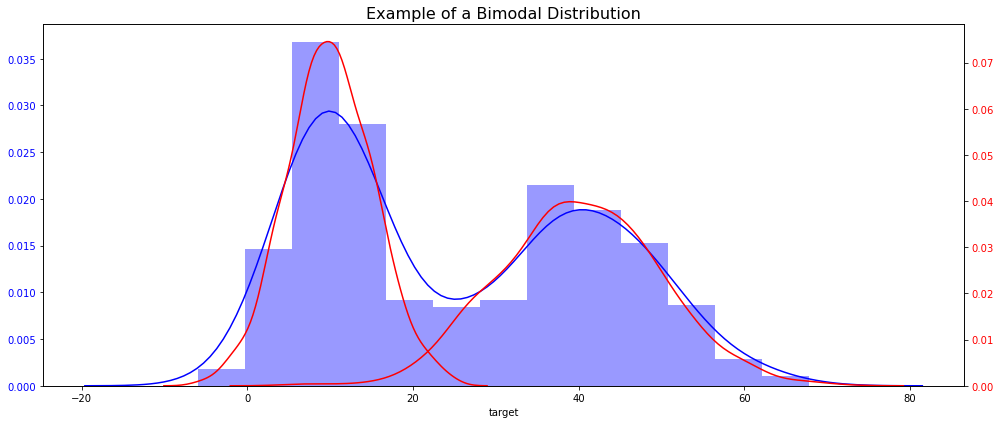

In [10]:
df = pd.DataFrame({'feature1' : np.random.normal(10, 5, 1000),
                   'feature2' : np.random.normal(40, 10, 1000),
                   'feature3' : np.random.randint(0, 2, 1000),
                  })

df['target'] = df.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else x.feature2, axis=1)

display(df.head())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
color = 'blue'
sns.distplot(df.target, ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
sns.distplot(df.feature1, ax=ax2, color=color, hist=False)
sns.distplot((df.feature2), ax=ax2, color=color, hist=False)

ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Example of a Bimodal Distribution', fontsize=16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Let's use our baseline model as is and use it for modelling the data.
From the below results, we can see that the LightGBM model is able to handle the bimodal distribution.

Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.826822	valid_1's rmse: 0.815634
[100]	training's rmse: 0.672937	valid_1's rmse: 0.791301
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.672937	valid_1's rmse: 0.791301
RMSE: 0.79130

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.873957	valid_1's rmse: 0.843259
[100]	training's rmse: 0.709883	valid_1's rmse: 0.762916
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.709883	valid_1's rmse: 0.762916
RMSE: 0.76292

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703871	valid_1's rmse: 1.30502
[100]	training's rmse: 0.563548	valid_1's rmse: 1.15732
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.563548	valid_1's rmse: 1.15732
RMSE: 1.15732

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.

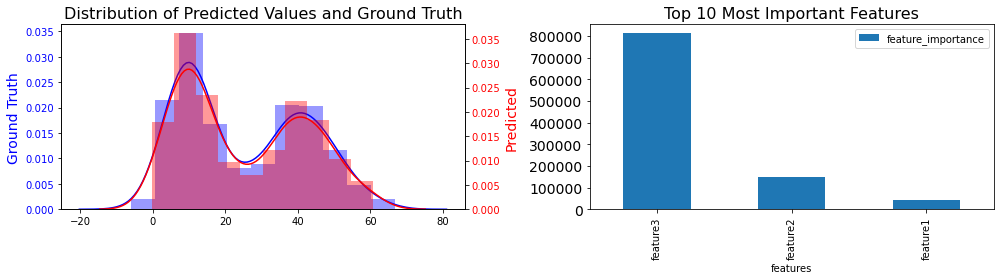

In [11]:
features = df.columns[df.columns.str.startswith('feature')]
target = ['target']

pred = run_model(df[features].head(800), 
          df[target].head(800), 
          df[features].tail(200))


# Feature Engineering Techniques

We have seen that our baseline model in theory is able to model the bimodal distribution of our target. However, we can also see that this highly depends on the quality of our features. In the [Data Overview](#Data-Overview), we saw that the features have a low absolute correlation to the target. In this section, we will be exploring different feature engineering techniques.

## Gaussian Mixture Modelling (GMM)

We can use Gaussian Mixture Modelling to separate the two distributions. It is an unsupervised learning algorithm.

[Discussion: When you have bimodal distribution](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/86951)

In [12]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)

gmm.fit(train_df.target.values.reshape(-1, 1))

train_df['target_class'] = gmm.predict(train_df.target.values.reshape(-1, 1))

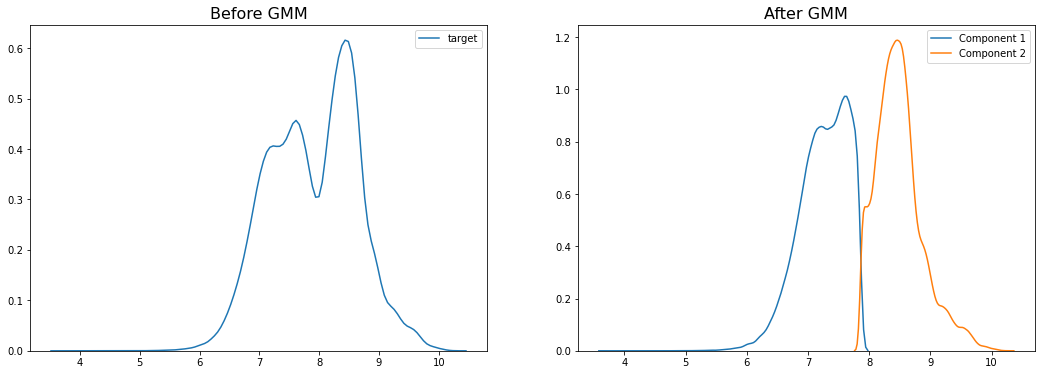

In [13]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.kdeplot(data=train_df.target, ax=ax[0])
ax[0].set_title('Before GMM', fontsize=16)
sns.kdeplot(data=train_df[train_df.target_class==0].target, label='Component 1', ax=ax[1])
sns.kdeplot(data=train_df[train_df.target_class==1].target, label='Component 2', ax=ax[1])
ax[1].set_title('After GMM', fontsize=16)
plt.show()

Since the features have multimodal distributions, it would be worthwhile checking what happens if we add a GMM feature for each `cont#` feature. 

In [14]:

def get_gmm_class_feature(feat, n):
    gmm = GaussianMixture(n_components=n, random_state=42)

    gmm.fit(train_df[feat].values.reshape(-1, 1))

    train_df[f'{feat}_class'] = gmm.predict(train_df[feat].values.reshape(-1, 1))
    test_df[f'{feat}_class'] = gmm.predict(test_df[feat].values.reshape(-1, 1))

get_gmm_class_feature('cont1', 4)
get_gmm_class_feature('cont2', 10)
get_gmm_class_feature('cont3', 6)
get_gmm_class_feature('cont4', 4)
get_gmm_class_feature('cont5', 3)
get_gmm_class_feature('cont6', 2)
get_gmm_class_feature('cont7', 3)
get_gmm_class_feature('cont8', 4)
get_gmm_class_feature('cont9', 4)
get_gmm_class_feature('cont10', 8)
get_gmm_class_feature('cont11', 5)
get_gmm_class_feature('cont12', 4)
get_gmm_class_feature('cont13', 6)
get_gmm_class_feature('cont14', 6)

train_df.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cont5_class,cont6_class,cont7_class,cont8_class,cont9_class,cont10_class,cont11_class,cont12_class,cont13_class,cont14_class
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,...,0,1,2,0,2,7,4,2,2,2
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,...,1,0,0,2,3,0,3,0,1,0
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,...,1,1,0,2,2,1,1,1,2,2
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,...,0,1,2,1,2,4,1,2,2,2
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,...,1,1,0,2,1,7,4,2,2,0


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,cont1_class,cont2_class,cont3_class,cont4_class,cont5_class,cont6_class,cont7_class,cont8_class,cont9_class,cont10_class,cont11_class,cont12_class,cont13_class,cont14_class
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,2,5,4,0,0,1,2,0,2,7,4,2,2,2
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,3,7,4,2,1,0,0,2,3,0,3,0,1,0
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,1,4,5,0,1,1,0,2,2,1,1,1,2,2
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,1,2,0,1,0,1,2,1,2,4,1,2,2,2
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,1,8,5,3,1,1,0,2,1,7,4,2,2,0


Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703775	valid_1's rmse: 0.705308
[100]	training's rmse: 0.696122	valid_1's rmse: 0.701261
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696122	valid_1's rmse: 0.701261
RMSE: 0.70126

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703906	valid_1's rmse: 0.704643
[100]	training's rmse: 0.696454	valid_1's rmse: 0.700832
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696454	valid_1's rmse: 0.700832
RMSE: 0.70083

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703002	valid_1's rmse: 0.70824
[100]	training's rmse: 0.695428	valid_1's rmse: 0.703999
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.695428	valid_1's rmse: 0.703999
RMSE: 0.70400

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 

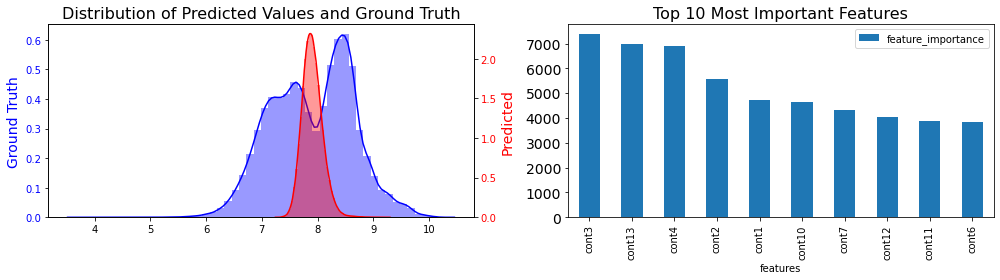

In [15]:
features = list(features_baseline) + list(train_df.columns[train_df.columns.str.contains('class') & ~train_df.columns.str.contains('target')])
target = ['target']

display(train_df[features].head().style.set_caption('Training data'))

y_test_pred = run_model(train_df[features], 
          train_df[target], 
          test_df[features])

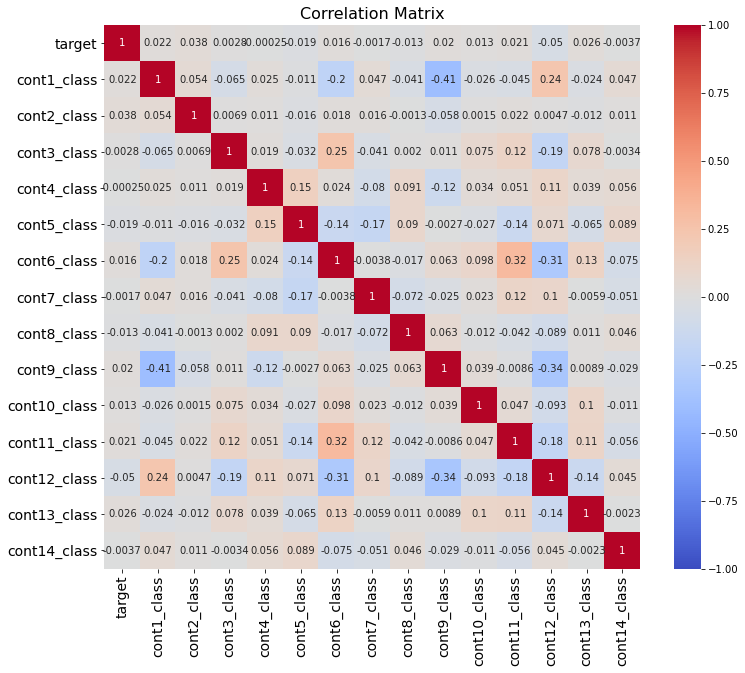

In [16]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
cols = ['target', 'cont1_class', 'cont2_class', 'cont3_class',
       'cont4_class', 'cont5_class', 'cont6_class', 'cont7_class',
       'cont8_class', 'cont9_class', 'cont10_class', 'cont11_class',
       'cont12_class', 'cont13_class', 'cont14_class']
sns.heatmap(train_df[cols].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

With the newly added features, we get a RMSE of **0.703054**. This is only a 0.000094 improvement to our baseline and our distribution is still not close to the distribution of the ground truth.

Let's try another idea: What happens if we use the classes we got from the GMM to separate each feature:

In [17]:
for j in range(1,15):
    for i in range(train_df.cont1_class.nunique()):
        train_df[f'cont{j}_class_{i+1}'] = np.where(train_df[f'cont{j}_class'] == (i+1), train_df[f'cont{j}'], np.nan)
        test_df[f'cont{j}_class_{i+1}'] = np.where(test_df[f'cont{j}_class'] == (i+1), test_df[f'cont{j}'], np.nan)
        


In [18]:
train_df[['cont1', 'cont1_class', 'cont1_class_1', 'cont1_class_2', 'cont1_class_3']].head().style.set_caption('Example of newly created features for cont1 from cont1_class')

,cont1,cont1_class,cont1_class_1,cont1_class_2,cont1_class_3
0,0.670390,2,nan,0.670390,nan
1,0.388053,3,nan,nan,0.388053
2,0.834950,1,0.834950,nan,nan
3,0.820708,1,0.820708,nan,nan
4,0.935278,1,0.935278,nan,nan


,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,cont1_class_1,cont1_class_2,cont1_class_3,cont1_class_4,cont2_class_1,cont2_class_2,cont2_class_3,cont2_class_4,cont3_class_1,cont3_class_2,cont3_class_3,cont3_class_4,cont4_class_1,cont4_class_2,cont4_class_3,cont4_class_4,cont5_class_1,cont5_class_2,cont5_class_3,cont5_class_4,cont6_class_1,cont6_class_2,cont6_class_3,cont6_class_4,cont7_class_1,cont7_class_2,cont7_class_3,cont7_class_4,cont8_class_1,cont8_class_2,cont8_class_3,cont8_class_4,cont9_class_1,cont9_class_2,cont9_class_3,cont9_class_4,cont10_class_1,cont10_class_2,cont10_class_3,cont10_class_4,cont11_class_1,cont11_class_2,cont11_class_3,cont11_class_4,cont12_class_1,cont12_class_2,cont12_class_3,cont12_class_4,cont13_class_1,cont13_class_2,cont13_class_3,cont13_class_4,cont14_class_1,cont14_class_2,cont14_class_3,cont14_class_4
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,nan,0.670390,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.643968,nan,nan,nan,nan,nan,nan,nan,nan,0.855953,nan,nan,nan,nan,0.890700,nan,nan,nan,nan,nan,nan,nan,0.558245,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.921832,nan,0.866772,nan,nan,nan,0.878733,nan,nan,nan,0.305411,nan,nan
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,nan,nan,0.388053,nan,nan,nan,nan,nan,nan,nan,nan,0.686102,nan,0.501149,nan,nan,0.643790,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.580748,nan,nan,nan,nan,0.418335,nan,nan,nan,nan,nan,nan,nan,0.439872,nan,nan,nan,nan,nan,0.369957,nan,nan,nan,nan,nan,nan,nan
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,0.834950,nan,nan,nan,nan,nan,nan,0.227436,nan,nan,nan,nan,nan,nan,nan,nan,0.606839,nan,nan,nan,0.829175,nan,nan,nan,nan,nan,nan,nan,nan,0.558771,nan,nan,nan,0.587603,nan,nan,0.823312,nan,nan,nan,0.567007,nan,nan,nan,0.677708,nan,nan,nan,nan,0.882938,nan,nan,nan,0.303047,nan,nan
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,0.820708,nan,nan,nan,nan,0.160155,nan,nan,nan,nan,nan,nan,0.726104,nan,nan,nan,nan,nan,nan,nan,0.785108,nan,nan,nan,nan,0.752758,nan,nan,0.823267,nan,nan,nan,nan,0.574466,nan,nan,nan,nan,nan,0.580843,0.769594,nan,nan,nan,nan,0.818143,nan,nan,nan,0.914281,nan,nan,nan,0.279528,nan,nan
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,0.935278,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.880214,nan,0.665610,nan,nan,nan,0.830131,nan,nan,nan,nan,nan,nan,nan,nan,0.604157,nan,nan,0.874658,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.983575,nan,0.900464,nan,nan,nan,0.935918,nan,nan,nan,nan,nan,nan


Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.702782	valid_1's rmse: 0.705152
[100]	training's rmse: 0.694748	valid_1's rmse: 0.701308
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.694748	valid_1's rmse: 0.701308
RMSE: 0.70131

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703381	valid_1's rmse: 0.70475
[100]	training's rmse: 0.695091	valid_1's rmse: 0.700706
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.695091	valid_1's rmse: 0.700706
RMSE: 0.70071

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.702369	valid_1's rmse: 0.70827
[100]	training's rmse: 0.694022	valid_1's rmse: 0.704107
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.694022	valid_1's rmse: 0.704107
RMSE: 0.70411

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0

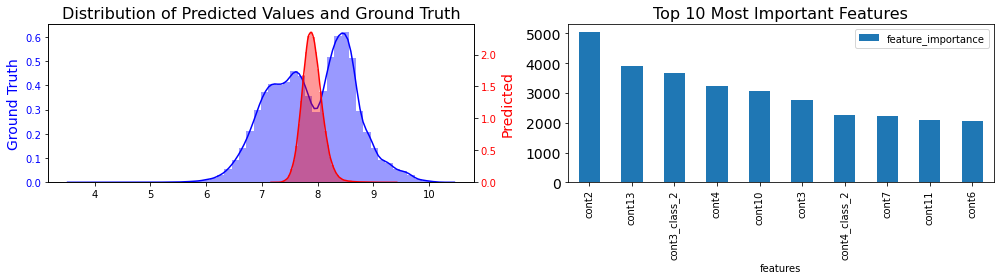

In [19]:
features = list(features_baseline) + list(train_df.columns[train_df.columns.str.contains('class_')])
target = ['target']

display(train_df[features].head().style.set_caption('Training data'))

y_test_pred = run_model(train_df[features], 
          train_df[target], 
          test_df[features])

## Binning

Work in progress

In [20]:
for i in range(1,15):
    train_df[f'cont{i}_bin_10'] = pd.cut(train_df[f'cont{i}'], bins=10, labels=False)
    test_df[f'cont{i}_bin_10'] = pd.cut(test_df[f'cont{i}'], bins=10, labels=False)

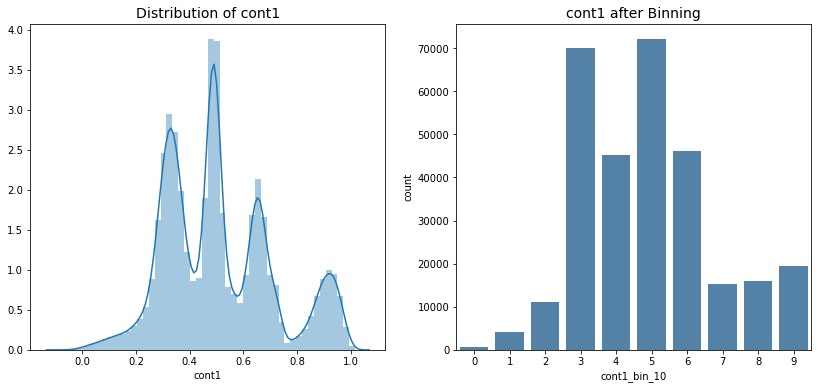

In [21]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.distplot(train_df['cont1'], ax=ax[0])
ax[0].set_title('Distribution of cont1', fontsize=14)
sns.countplot(train_df['cont1_bin_10'], ax=ax[1], color='steelblue')
ax[1].set_title('cont1 after Binning', fontsize=14)

plt.show()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,cont1_bin_10,cont2_bin_10,cont3_bin_10,cont4_bin_10,cont5_bin_10,cont6_bin_10,cont7_bin_10,cont8_bin_10,cont9_bin_10,cont10_bin_10,cont11_bin_10,cont12_bin_10,cont13_bin_10,cont14_bin_10
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,6,9,6,1,0,8,8,0,6,6,8,8,8,1
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,4,7,6,4,4,3,5,4,5,4,3,3,3,2
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,8,2,2,1,4,7,5,4,6,7,5,6,8,1
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,8,2,5,6,0,7,7,7,6,5,7,7,9,1
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,9,5,2,8,5,7,5,4,8,7,9,8,9,3


Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.704053	valid_1's rmse: 0.705555
[100]	training's rmse: 0.696261	valid_1's rmse: 0.701308
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696261	valid_1's rmse: 0.701308
RMSE: 0.70131

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.704036	valid_1's rmse: 0.704602
[100]	training's rmse: 0.696528	valid_1's rmse: 0.70078
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696528	valid_1's rmse: 0.70078
RMSE: 0.70078

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.70317	valid_1's rmse: 0.708544
[100]	training's rmse: 0.695646	valid_1's rmse: 0.704216
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.695646	valid_1's rmse: 0.704216
RMSE: 0.70422

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.

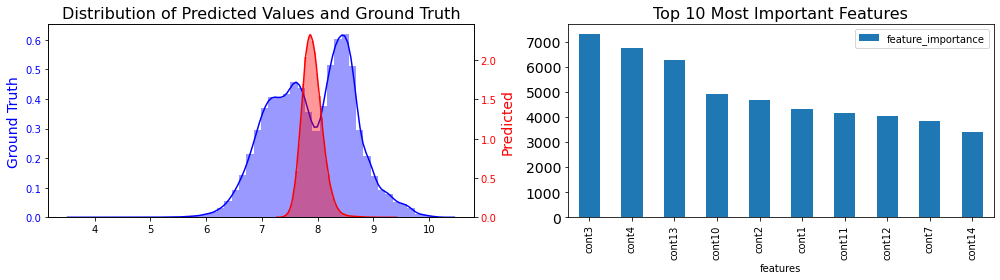

In [22]:
features = list(features_baseline) + list(train_df.columns[train_df.columns.str.contains('bin')])
target = ['target']

display(train_df[features].head().style.set_caption('Training data'))

y_test_pred = run_model(train_df[features], 
          train_df[target], 
          test_df[features])

## Statistical Features
Another common approach is to create new features from the data's **statistics (mean, sum, std, etc.)**.

In [23]:
features = train_df.columns[train_df.columns.str.startswith('cont') & ~train_df.columns.str.contains('class')& ~train_df.columns.str.contains('bin')]

train_df['sum'] = train_df[features].sum(axis=1)
train_df['mean'] = train_df[features].mean(axis=1)
train_df['min'] = train_df[features].min(axis=1)
train_df['max'] = train_df[features].max(axis=1)
train_df['std'] = train_df[features].std(axis=1)
train_df['var'] = train_df[features].var(axis=1)

test_df['sum'] = test_df[features].sum(axis=1)
test_df['mean'] = test_df[features].mean(axis=1)
test_df['min'] = test_df[features].min(axis=1)
test_df['max'] = test_df[features].max(axis=1)
test_df['std'] = test_df[features].std(axis=1)
test_df['var'] = test_df[features].var(axis=1)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,sum,mean,min,max,std
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,9.044174,0.646012,0.284117,0.921832,0.254002
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,6.846826,0.489059,0.369484,0.686102,0.104876
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.999923,0.571423,0.227436,0.882938,0.224308
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,8.834286,0.631020,0.160155,0.914281,0.237707
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,10.121354,0.722954,0.303801,0.983575,0.230560


Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703732	valid_1's rmse: 0.705453
[100]	training's rmse: 0.696105	valid_1's rmse: 0.70151
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696105	valid_1's rmse: 0.70151
RMSE: 0.70151

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.704042	valid_1's rmse: 0.70453
[100]	training's rmse: 0.696359	valid_1's rmse: 0.700596
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.696359	valid_1's rmse: 0.700596
RMSE: 0.70060

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.703208	valid_1's rmse: 0.708599
[100]	training's rmse: 0.695455	valid_1's rmse: 0.704349
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.695455	valid_1's rmse: 0.704349
RMSE: 0.70435

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.

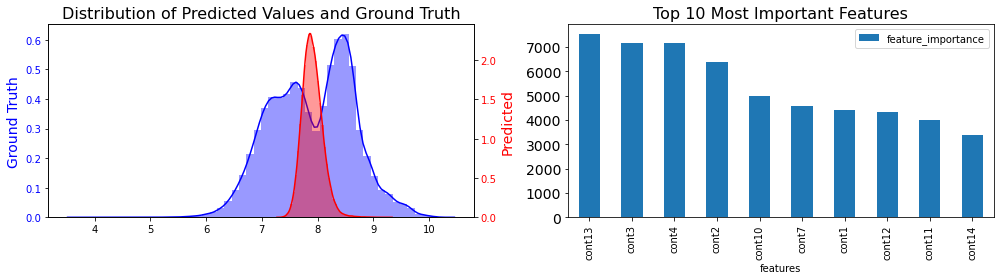

In [24]:
features = list(features_baseline) + list(['sum', 'mean', 'min', 'max', 'std'])
target = ['target']

display(train_df[features].head().style.set_caption('Training data'))

y_test_pred = run_model(train_df[features], 
          train_df[target], 
          test_df[features])

## Deep Feature Synthesis
Another common approach is creating new features by combining features with **basic mathematical operations (addition, subtraction, multiplication, division)**.
If we were given the names of each feature, we could start by creating new features based on our intuition. For example if you have two features `hours_spent_writing_kernels` and
`number_of_kernels`, you could combine them by dividion to get a new feature `average_time_to_write_a_kernel`= `hours_spent_writing_kernels`/`number_of_kernels`.

However, in this challenge we do not have any information about the features. Therefore, we cannot create new features by intuition. An idea would be to randomly combine features and hoping to see a correlation to our target. However, for 14 features that will take a lot of time. We can somewhat automate this with Deep Feature Synthesis.

If you wanto read more about this topic in depth, I highly recommend this kernel: [Automated Feature Engineering Tutorial](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-tutorial).

In [25]:
import featuretools as ft
es = ft.EntitySet(id = 'data')

original_cols = ['id', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


es = es.entity_from_dataframe(entity_id = 'data', 
                              dataframe = pd.concat([train_df, test_df], axis=0)[original_cols], 
                              index = 'id', 
                              time_index = None)
es['data']

Entity: data
  Variables:
    id (dtype: index)
    cont1 (dtype: numeric)
    cont2 (dtype: numeric)
    cont3 (dtype: numeric)
    cont4 (dtype: numeric)
    cont5 (dtype: numeric)
    cont6 (dtype: numeric)
    cont7 (dtype: numeric)
    cont8 (dtype: numeric)
    cont9 (dtype: numeric)
    cont10 (dtype: numeric)
    cont11 (dtype: numeric)
    cont12 (dtype: numeric)
    cont13 (dtype: numeric)
    cont14 (dtype: numeric)
  Shape:
    (Rows: 499999, Columns: 15)

You can list out all possibilities with the function `list_primitives()`.

In [26]:
ft.list_primitives().head()

,name,type,dask_compatible,koalas_compatible,description
0,std,aggregation,True,True,Computes the dispersion relative to the mean v...
1,trend,aggregation,False,False,Calculates the trend of a variable over time.
2,count,aggregation,True,True,"Determines the total number of values, excludi..."
3,last,aggregation,False,False,Determines the last value in a list.
4,median,aggregation,False,False,Determines the middlemost number in a list of ...


Let's try a couple of primitives. How about dividing each feature by another feature using the primitive `divide_numeric`. You can see that we **end up with 196 features**.

In [27]:
new_features, new_feature_names = ft.dfs(entityset = es, target_entity = 'data', 
                                 trans_primitives = ['divide_numeric'])

new_features.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cont9 / cont12,cont9 / cont13,cont9 / cont14,cont9 / cont2,cont9 / cont3,cont9 / cont4,cont9 / cont5,cont9 / cont6,cont9 / cont7,cont9 / cont8
id,,,,,,,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,...,0.644051,0.635285,1.827848,0.688088,0.866883,1.913166,1.964841,0.652192,0.626749,1.955037
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,...,0.961755,1.130765,1.132214,0.673534,0.609727,0.834752,0.649801,0.930037,0.818942,0.720338
4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,...,0.867045,0.665509,1.938983,2.583594,1.948391,2.002680,0.968301,0.708660,1.160942,1.051599
5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,...,0.702159,0.628325,2.055132,3.586938,1.050429,0.791162,2.033914,0.731704,0.763148,0.697789
8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,...,0.971342,0.934546,2.007145,2.076413,2.879052,0.993688,1.314070,1.053640,1.795597,1.447733


Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.702375	valid_1's rmse: 0.70497
[100]	training's rmse: 0.693627	valid_1's rmse: 0.701303
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.693627	valid_1's rmse: 0.701303
RMSE: 0.70130

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.702566	valid_1's rmse: 0.704087
[100]	training's rmse: 0.693993	valid_1's rmse: 0.700476
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.693993	valid_1's rmse: 0.700476
RMSE: 0.70048

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.701937	valid_1's rmse: 0.708649
[100]	training's rmse: 0.693148	valid_1's rmse: 0.704294
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.693148	valid_1's rmse: 0.704294
RMSE: 0.70429

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 

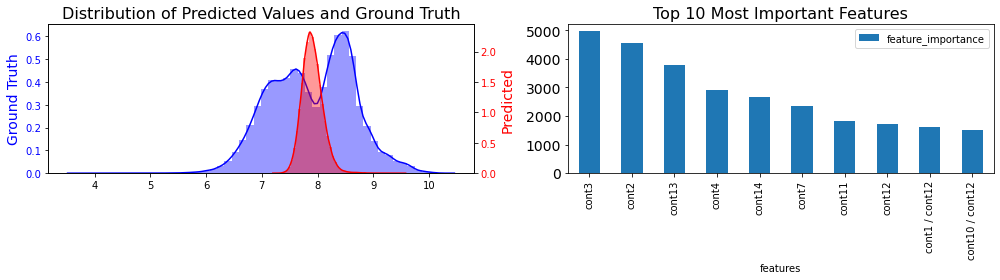

In [28]:
new_features = new_features.reset_index(drop=False)
y_test_pred = run_model(new_features[new_features.id.isin(train_df.id)],
                        train_df[target], 
                        new_features[new_features.id.isin(test_df.id)])

Let's also try it for multiplication:

In [29]:
new_features, new_feature_names = ft.dfs(entityset = es, target_entity = 'data', 
                                 trans_primitives = ['multiply_numeric'])

new_features.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cont5 * cont6,cont5 * cont7,cont5 * cont8,cont5 * cont9,cont6 * cont7,cont6 * cont8,cont6 * cont9,cont7 * cont8,cont7 * cont9,cont8 * cont9
id,,,,,,,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,...,0.243191,0.253063,0.081127,0.158607,0.762398,0.244411,0.477832,0.254332,0.497229,0.159403
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,...,0.289580,0.328863,0.373880,0.269320,0.229771,0.261223,0.188169,0.296660,0.213695,0.242947
4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,...,0.503176,0.307148,0.339084,0.356581,0.419682,0.463319,0.487226,0.282818,0.297412,0.328336
5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,...,0.221749,0.212612,0.232527,0.162254,0.590996,0.646353,0.451018,0.619721,0.432434,0.472939
8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,...,0.552543,0.324227,0.402133,0.582182,0.404367,0.501529,0.726081,0.294293,0.426057,0.528431


Fold 1:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.702183	valid_1's rmse: 0.70462
[100]	training's rmse: 0.694051	valid_1's rmse: 0.701191
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.694051	valid_1's rmse: 0.701191
RMSE: 0.70119

Fold 2:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.702413	valid_1's rmse: 0.704163
[100]	training's rmse: 0.694287	valid_1's rmse: 0.700729
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.694287	valid_1's rmse: 0.700729
RMSE: 0.70073

Fold 3:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.701441	valid_1's rmse: 0.708093
[100]	training's rmse: 0.693336	valid_1's rmse: 0.704543
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.693336	valid_1's rmse: 0.704543
RMSE: 0.70454

Fold 4:
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 

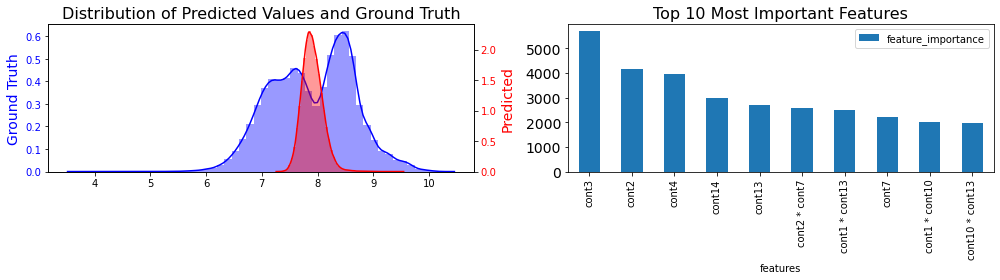

In [30]:
new_features = new_features.reset_index(drop=False)
y_test_pred = run_model(new_features[new_features.id.isin(train_df.id)],
                        train_df[target], 
                        new_features[new_features.id.isin(test_df.id)])

## Summary

So far, the feature engineering techniques only gave us minor improvements: 

|           | OOF RMSE | Delta to Benchmark |
|:---------:|----------|--------------------|
| **Benchmark** | **0.703148** | n/a                |
| GMM (class)       | 0.703054 | 0.000094           |
| GMM (separated)      | 0.703033 | **0.000115**           |
| Binning   | 0.703237 | -0.000089          |
| Statistical Features   | 0.703229 | -0.00081|
| DFS (divide_numeric)  | 0.703145 | 0.00003|
| DFS (multiply_numeric)  | 0.0.703144 | 0.00004|



In contrast to the other feature engineering techniques, with the binning features we get a worse score than with the other techniques. This is probably due to the fact that although we have more features now, a. they are highly correlated to each other (e.g. collinearity between `cont1` and `cont1_bin10`) and b. we lose some information when binning features.

# EDA

From above section, we understand the urgency of gaining some insights from the data. For this purpose, we will concatenate the training and the testing data and sort them by the column `id`.

In [31]:
merged_df = pd.concat([train_df, test_df], axis=0).sort_values(by='id').reset_index(drop=True)

In [32]:
original_cols = ['id', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'target']

display(merged_df[original_cols].head().style.set_caption('Merged Dataframe for EDA'))

merged_df[original_cols].describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,0,0.353600,0.738780,0.600939,0.293377,0.285691,0.458006,0.620704,0.422249,0.369203,0.435727,0.550540,0.699134,0.286864,0.364515,nan
1,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
2,2,0.907222,0.189756,0.215531,0.869915,0.301333,0.528958,0.390351,0.521112,0.794779,0.798580,0.446475,0.449037,0.916964,0.513002,nan
3,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
4,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091


,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
count,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,499999.000000,299999.000000
mean,249999.431793,0.507013,0.497970,0.521487,0.515331,0.502122,0.526704,0.487823,0.525212,0.460018,0.520511,0.484031,0.506832,0.553821,0.503497,7.905688
std,144337.847915,0.204074,0.228042,0.200724,0.233020,0.220744,0.218004,0.180979,0.216166,0.196897,0.201770,0.220038,0.218807,0.229730,0.208275,0.732930
min,0.000000,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.109759,0.078859,0.088635,0.015367,0.164500,3.700459
25%,124999.500000,0.343275,0.320621,0.344155,0.294686,0.284111,0.356237,0.346879,0.341740,0.330800,0.375485,0.300768,0.310458,0.350663,0.308502,7.329373
50%,249999.000000,0.484127,0.553189,0.551449,0.482552,0.451821,0.470993,0.466646,0.483562,0.416870,0.458773,0.441966,0.486139,0.489284,0.431515,7.940576
75%,374999.500000,0.643904,0.730636,0.648451,0.748106,0.670738,0.694178,0.581041,0.685178,0.575112,0.700236,0.678597,0.694536,0.768809,0.712660,8.470087
max,499999.000000,1.017577,0.859697,1.006955,1.010402,1.034261,1.046715,1.066167,1.026280,1.004114,1.199951,1.023151,1.049417,0.977845,0.868679,10.267569


Let's see if we can get any interesting insights if we difference the features with `np.diff`. Differencing means that we take the difference between two consecutive datapoints of a column.

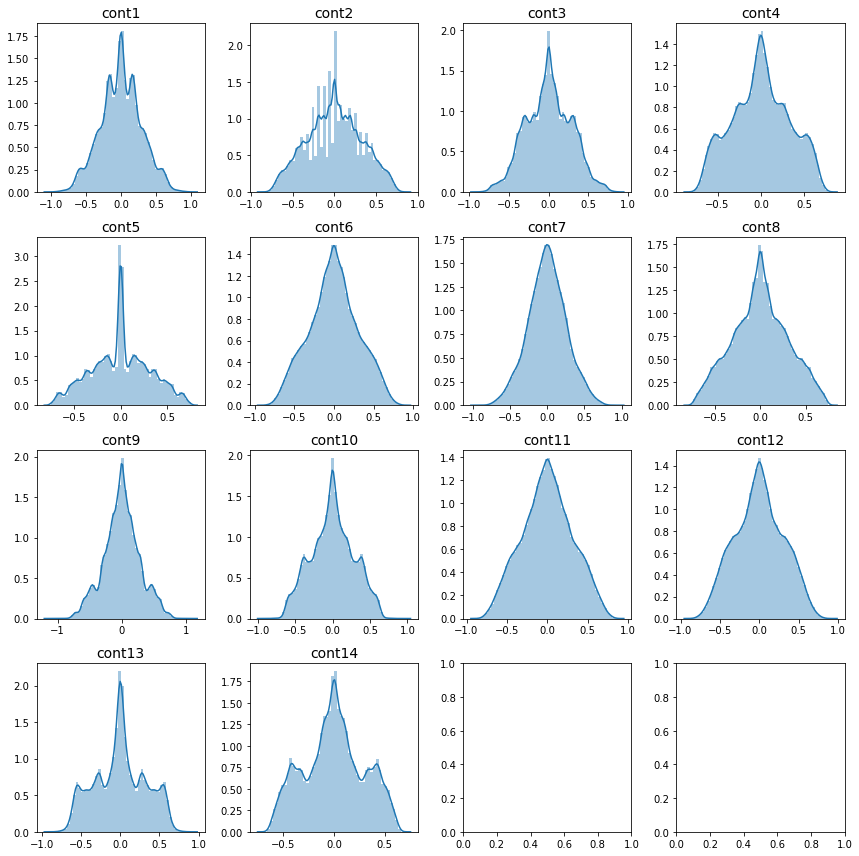

In [33]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

#f.suptitle('Differenced Features')
j= -1
for i in range(1,15):
    k = (i-1)%4 # ncols
    
    if k == 0:
        j += 1
        
    sns.distplot(np.diff(merged_df[f'cont{i}']), ax=ax[j, k])
    ax[j, k].set_title(f'cont{i}', fontsize=14)
plt.tight_layout()

plt.show()

Log transform

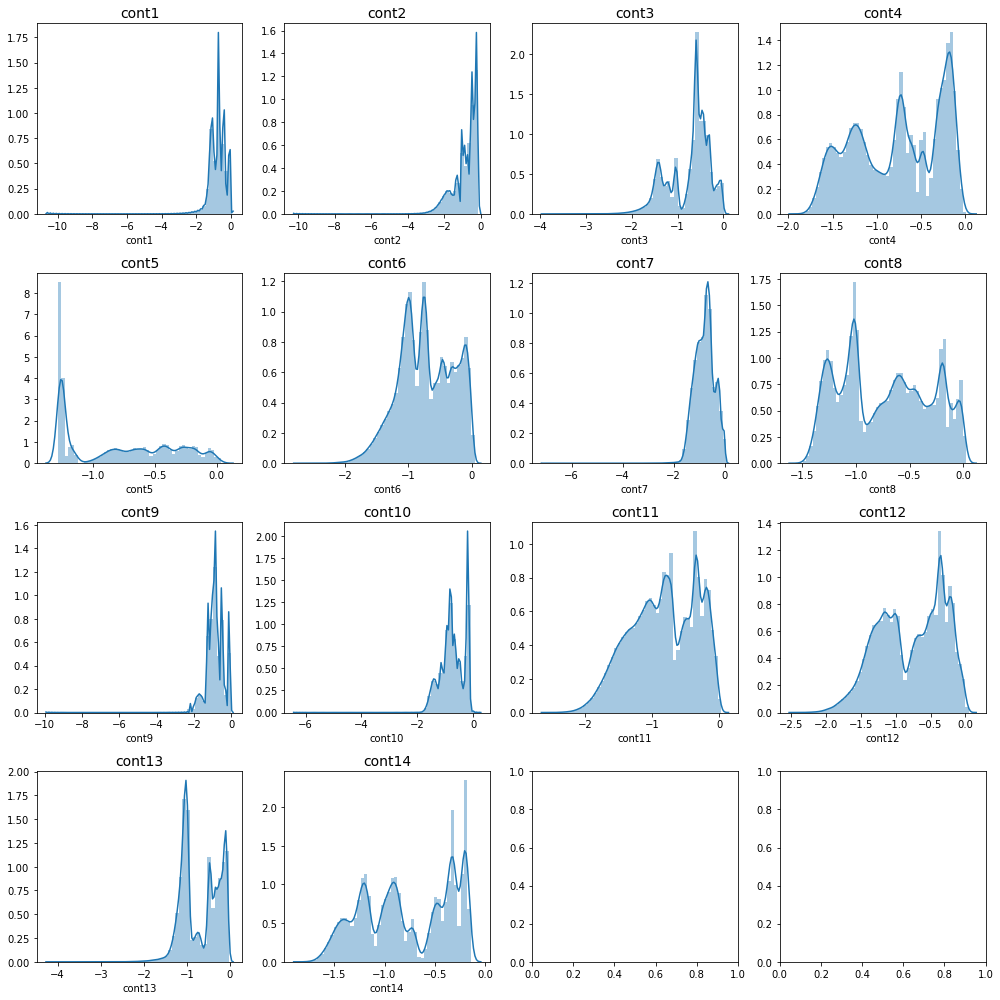

In [34]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

#f.suptitle('Log Features')
j= -1
for i in range(1,15):
    k = (i-1)%4 # ncols
    
    if k == 0:
        j += 1
        
    sns.distplot(np.log(merged_df[f'cont{i}']), ax=ax[j, k])
    ax[j, k].set_title(f'cont{i}', fontsize=14)
    
plt.tight_layout()
plt.show()

From the above experiments, we can see that `cont2`, `cont3`, `cont4` and `cont13` seem to be the most important features for our model. Let's explore them a little more.

Hopefully you now have a few ideas on how to investigate the features. If you need more inspiration, I recommend the discussion section of the [BNP Paribas Cardif Claims Management Competition](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/discussion).

Happy Kaggling!

# Submission

In [35]:
submission = test_df[['id']].copy()
submission['target'] = y_test_pred

submission.to_csv("submission.csv", index=False)